## Clustering Analysis

In this notebook, we show our cluster analysis comparing play styles in Club (NBA + other international) leagues and FIBA. Our approach is to use K-means clustering to cluster players from the three leagues, and then analyze the way players map from cluster to cluster across club play and FIBA play. We use play type distributions parsed from the Synergy data as the features for our clustering. We also list some of our observations and next steps.

## Load Data
We load three sheets with results from parsing the Synergy data for FIBA, NBA and International competitions, and merge the three dataframes. We remove any rows with fewer than 50 total plays.

In [1]:
import pandas as pd
df_FIBA = pd.read_csv("FIBA_Play_Counts.csv", encoding='latin-1')
df_FIBA.rename(columns={"Unnamed: 0": "Player"}, inplace=True)
df_FIBA['Source'] = 'FIBA'
df_FIBA.head()

,Player,P&R Ball Handler,Spot-Up,Transition,ISO,Post-Up,P&R Roll Man,Cut,Offensive Rebound,Off Screen,Hand Off,Total,Source
0,Ricky Rubio,284,121,64,20,0,0,9,25,7,16,546,FIBA
1,Luis Scola,0,122,105,19,304,167,125,97,20,1,960,FIBA
2,Rudy Fernandez,109,103,54,33,0,1,20,37,36,12,405,FIBA
3,Juancho Hernangomez,2,53,25,5,5,8,26,35,13,1,173,FIBA
4,Pierre Oriola,0,21,10,0,3,8,18,38,1,1,100,FIBA


In [2]:
df_INTL = pd.read_csv("INTL_Play_Counts.csv", encoding='latin-1')
df_INTL.rename(columns={"Unnamed: 0": "Player"}, inplace=True)
df_INTL['Source'] = 'INTL'
df_INTL.head()

,Player,P&R Ball Handler,Spot-Up,Transition,ISO,Post-Up,P&R Roll Man,Cut,Offensive Rebound,Off Screen,Hand Off,Total,Source
0,Jerome Randle,2780,417,638,633,0,1,67,99,107,173,4915,INTL
1,Elmedin Kikanovic,9,277,173,29,986,761,519,424,21,5,3204,INTL
2,Rickey Paulding,848,925,382,353,282,12,231,265,378,62,3738,INTL
3,Casper Ware,2059,471,430,637,4,1,48,76,166,185,4077,INTL
4,Daniel Johnson,32,474,373,84,853,348,331,399,43,25,2962,INTL


In [3]:
df_NBA = pd.read_csv('NBA_PLAY_COUNTS.csv', encoding='latin-1')
df_NBA.rename(columns={"Unnamed: 0": "Player"}, inplace=True)
df_NBA['Source'] = 'NBA'
df_NBA.head()

,Player,P&R Ball Handler,Spot-Up,Transition,ISO,Post-Up,P&R Roll Man,Cut,Offensive Rebound,Off Screen,Hand Off,Total,Source
0,Dwyane Wade,4872,818,1207,1149,1232,26,484,437,396,364,10985,NBA
1,Danny Green,751,2193,1168,127,42,21,212,350,512,282,5658,NBA
2,Lebron James,863,199,477,612,514,64,121,92,86,7,3035,NBA
3,Kawhi Leonard,3109,1734,1487,1471,1223,60,310,605,523,463,10985,NBA
4,Tim Duncan,6,280,169,98,1235,757,635,556,52,13,3801,NBA


In [4]:
df = pd.concat([df_NBA, df_INTL, df_FIBA]).reset_index()
s = df['Player'].value_counts()
##df[df['Player'].isin(s[s>=2].index)]
df['Type'] = df['Source'].apply(lambda x: 'FIBA' if x=='FIBA' else 'Club')
df

,index,Player,P&R Ball Handler,Spot-Up,Transition,ISO,Post-Up,P&R Roll Man,Cut,Offensive Rebound,Off Screen,Hand Off,Total,Source,Type
0,0,Dwyane Wade,4872,818,1207,1149,1232,26,484,437,396,364,10985,NBA,Club
1,1,Danny Green,751,2193,1168,127,42,21,212,350,512,282,5658,NBA,Club
2,2,Lebron James,863,199,477,612,514,64,121,92,86,7,3035,NBA,Club
3,3,Kawhi Leonard,3109,1734,1487,1471,1223,60,310,605,523,463,10985,NBA,Club
4,4,Tim Duncan,6,280,169,98,1235,757,635,556,52,13,3801,NBA,Club
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8654,2868,Chin Yong Wong,0,2,1,0,0,0,0,0,0,0,3,FIBA,FIBA
8655,2869,Wee Seng Wong,1,5,0,0,0,0,0,0,0,0,6,FIBA,FIBA
8656,2870,Min Joe Foong,0,0,0,0,0,0,0,0,0,0,0,FIBA,FIBA
8657,2871,Lok Seng Mak,0,1,0,0,0,0,1,0,0,0,2,FIBA,FIBA


Now, we convert the columns from play count totals to proportions, and prepare a dataframe to be passed into the clustering algorithm.

In [5]:
play_types = ['P&R Ball Handler', 'Spot-Up', 'Transition', 'ISO', 'Post-Up', 'P&R Roll Man', 'Cut', 'Offensive Rebound', 'Off Screen', 'Hand Off']
for p in play_types:
    df['% ' + p] = df[p] / df['Total']

In [6]:
df = df[df['Total'] >= 50].sort_values(['Source','Total'], ascending=[True, False])
filt_df = df[['% ' + p for p in play_types]].copy()

filt_df

,% P&R Ball Handler,% Spot-Up,% Transition,% ISO,% Post-Up,% P&R Roll Man,% Cut,% Offensive Rebound,% Off Screen,% Hand Off
5827,0.365904,0.173597,0.099792,0.097713,0.032225,0.001040,0.035343,0.032225,0.090437,0.071726
5787,0.000000,0.127083,0.109375,0.019792,0.316667,0.173958,0.130208,0.101042,0.020833,0.001042
5791,0.620438,0.077164,0.145985,0.072993,0.000000,0.002086,0.009385,0.025026,0.016684,0.030240
5937,0.734694,0.074114,0.062299,0.038668,0.003222,0.000000,0.016112,0.024705,0.020408,0.025779
7407,0.234554,0.136156,0.129291,0.170481,0.141876,0.002288,0.044622,0.025172,0.105263,0.010297
...,...,...,...,...,...,...,...,...,...,...
1300,0.117647,0.313725,0.274510,0.058824,0.000000,0.000000,0.039216,0.098039,0.019608,0.078431
1307,0.039216,0.254902,0.137255,0.039216,0.000000,0.098039,0.176471,0.215686,0.000000,0.039216
385,0.220000,0.160000,0.120000,0.160000,0.100000,0.040000,0.060000,0.080000,0.060000,0.000000
876,0.780000,0.060000,0.080000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000


## Clustering

We run K-means clustering for k (the number of clusters) between 5 and 15. We plot the inertia for each k. The inertia (also known as within-cluster sum-of-squares) measures how internally coherent each cluster is, with a lower inertia representing a better clustering model. See https://scikit-learn.org/stable/modules/clustering.html for more details.

In [7]:
from sklearn.cluster import KMeans
inertias = []
for i in range(5, 15):
    test_model = KMeans(n_clusters=i, random_state = 42)
    test_model.fit(filt_df)
    inertias.append(test_model.inertia_)
print(inertias)

[146.25803860551756, 130.39347043065956, 117.1710145578042, 110.91432339336451, 105.95518519490724, 101.73316726224688, 97.83896235584376, 94.39884198483551, 91.31903626876161, 88.32045021212714]


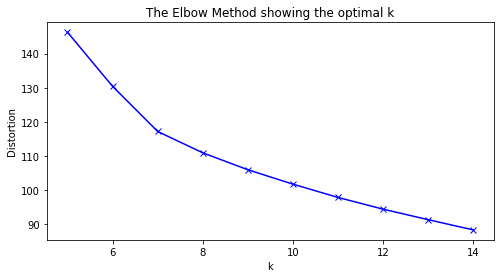

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(range(5,15), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From this, we see using the elbow method that the best number of clusters is 7. Therefore, let us run the model with 7 clusters again and analyze its results.

In [9]:
num_clusters = 7
test_model = KMeans(n_clusters=num_clusters, random_state = 42)
test_model.fit(filt_df)
filt_df['Cluster'] = test_model.labels_
filt_df['Cluster'].value_counts()

1    1127
2    1054
6    1041
0     856
4     796
3     732
5     557
Name: Cluster, dtype: int64

In [10]:
df['Cluster'] = filt_df['Cluster']

# Analysis

To get a sense of the different clusters, let's print a few players from each cluster. We print the players with the highest total play counts so they are most likely to be players from the NBA that we would recognize. Keep in mind that these stats are from previous NBA seasons, and some players' styles may have changed since then.

In [11]:
for i in range(num_clusters):
    print("Cluster "+ str(i))
    print(list(df['Player'].loc[filt_df[filt_df['Cluster'] == i].head(15).index]))
    print()

Cluster 0
['Andray Blatche', 'Dario Saric', 'Jonas Maciulis', 'Jianlian Yi', 'Makram Ben Romdhane', 'Ike Diogu', 'Mindaugas Kuzminskas', 'Eulis Baez', 'Ali Haidar', 'Georgios Printezis', 'Tornike Shengelia', 'Patrik Auda', 'Pavel Pumprla', 'Joji Takeuchi', 'Gabriel Deck']

Cluster 1
['Bogdan Bogdanovic', 'Marco Belinelli', 'Renaldas Seibutis', 'Ricky Rubio', 'Gregory Vargas', 'Francisco Cruz', 'Makoto Hiejima', 'Bruno Fitipaldo', 'Mateusz Ponitka', 'Jayson William', 'Pietro Aradori', 'Nando de Colo', 'Corey Webster', 'Carlos Morais', 'Evan Fournier']

Cluster 2
['Facundo Campazzo', 'Mantas Kalnietis', 'Nicolas Laprovittola', 'Dennis Schroder', 'Petteri Koponen', 'Goran Dragic', 'Sergio RodrÃ\xadguez', 'Jose Juan Barea', 'Tony Parker', 'Cory Joseph', 'Milos Teodosic', 'Mohammad Jamshidi', 'Krunoslav Simon', 'TomÃ¡s Satoransky', 'Janis Strelnieks']

Cluster 3
['Nestor Colmenares', 'Renaldo Balkman', 'Joffrey Lauvergne', 'Eloy Vargas', 'Marcos Delia', 'Jan Vesely', 'Mohammad Hussein', 'Ar

We also print out the average play type proportions for each cluster.

In [13]:
filt_df.groupby('Cluster').mean()

,% P&R Ball Handler,% Spot-Up,% Transition,% ISO,% Post-Up,% P&R Roll Man,% Cut,% Offensive Rebound,% Off Screen,% Hand Off
Cluster,,,,,,,,,,
0,0.019403,0.259131,0.105021,0.051340,0.169476,0.110060,0.112502,0.136909,0.029205,0.006952
1,0.419207,0.188883,0.127928,0.090431,0.016494,0.001256,0.027349,0.045000,0.051027,0.032425
2,0.595497,0.128285,0.090012,0.086280,0.005910,0.000381,0.013233,0.029437,0.023631,0.027332
3,0.002456,0.073625,0.070276,0.017541,0.157157,0.215006,0.214083,0.243829,0.004004,0.002023
4,0.057168,0.411540,0.137154,0.036200,0.046842,0.042102,0.078013,0.116625,0.056208,0.018149
5,0.002820,0.073507,0.055147,0.024284,0.357566,0.152968,0.152379,0.172986,0.006816,0.001527
6,0.216384,0.275954,0.160798,0.067466,0.028341,0.005115,0.047195,0.069168,0.090220,0.039359


These results generally make quite a lot of sense. Here are labels we came up with for the clusters, and the key play types for each.

0. Stretch bigs: Spot-Up, Post-Up, Offensive Rebound
1. Shooters: Spot-Up, Transition, Off Screen
2. Ball handlers: P&R Ball Handler, Isolation, Spot-Up
3. Driving bigs: Offensive Rebound, Cut, P&R Man
4. Slasher: Off Screen, Transition, Hand-Off, Spot-Up, P&R Ball Man
5. Low-post bigs: Post-Up, Offensive Rebound, P&R Man
6. Playmakers: Isolation, P&R Ball Handler, Spot-Up


We notice that clusters 2, 4, and 6 contain more traditional big-men, and expect confusuion between these. Meanwhile, clusters 1, 3, and 5 are also similar, so we expect confusion between these.

We create a confusion matrix mapping players' clusters from Club to FIBA, according to the format below:

| Club\FIBA  | 0 | 1 | 2 |
|-----------|---|---|---|
| 0         | 5 | 2 | 0 |
| 1         | 1 | 8 | 3 |
| 2         | 0 | 4 | 6 |

For example, the confusion matrix above shows that 8 players were clustered into cluster 1 for both leagues, while 2 players are clustered in cluster 0 for their Club stats but cluster 1 for their FIBA stats.

In [14]:
s = df['Player'].value_counts()
(s==2).value_counts()

False    4475
True      769
Name: Player, dtype: int64

In [15]:
s = df['Player'].value_counts()
all_leagues = s[s==3].index

df_2 = df.drop(df[(df['Player'].isin(all_leagues))&(df['Source']=='INTL')].index)

s = df_2['Player'].value_counts()
player_names = df_2['Player'].unique()
names_to_keep = []
for player in player_names:
    src = df_2[df_2['Player'] == player]['Type'].nunique()
    if src == 2:
        names_to_keep.append(player)

clust_df = df_2[df_2['Player'].isin(names_to_keep)]

nba_intl_df = clust_df[clust_df['Type'] == 'Club'].sort_values('Player')
fiba_df = clust_df[clust_df['Type'] == 'FIBA'].sort_values('Player')
if False in nba_intl_df['Player'].values == fiba_df['Player'].values:
    print("Some names do not match!")
else:
    print("All names match! Ready to create confusion matrix.")

All names match! Ready to create confusion matrix.


In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np
cm = confusion_matrix(nba_intl_df['Cluster'].values, fiba_df['Cluster'].values)
print("{:.2f}% of players stayed in the same cluster.".format(sum(np.diag(cm))/sum(sum(cm)) * 100))
pd.DataFrame(cm)

,0,1,2,3,4,5,6
0,67,1,0,6,13,7,2
1,0,65,30,0,1,0,22
2,0,33,103,0,0,0,0
3,8,0,0,44,0,22,0
4,14,3,0,0,33,0,17
5,7,0,0,9,1,55,0
6,7,16,4,0,14,0,53


Several observations:
- The number of players who stay in the same cluster is quite reasonable - a fair amount of players switch clusters, but not too many. This suggests that our model is capturing players' styles reasonably well, and that the number of clusters was appropriate.
- As expected, clusters 5 (Low-post bigs) and 3 (Driving bigs), and clusters 1 (Playmakers) and 5 (Slashers), show a lot of confusion. Interestingly, however, clusters 6 (Stretch bigs) and 3 (Ball handlers) also show high confusion. This is very surprising as cluster 6 contains mostly centres, while cluster 3 contains mostly guards.
- Confusion is in some cases one-sided. That is, for example, many players who were clustered in cluster 2 (Low-post bigs) in the NBA move to cluster 4 (Driving bigs) in FIBA. Likewise, many players in cluster 1 (Playmakers) move to cluster 3 (Ball handlers), many in cluster 5 (Slashers) move to cluster 1 (Playmakers), and many in cluster 6 (Stretch bigs) move to clusters 3 (Ball handlers) or 0 Shooters). This can be attributed to differences in the "global" play styles in FIBA vs. NBA. We take a deeper look at this below.

In [20]:
import numpy as np
sum(np.diag(cm))/sum(sum(cm))

0.639269406392694

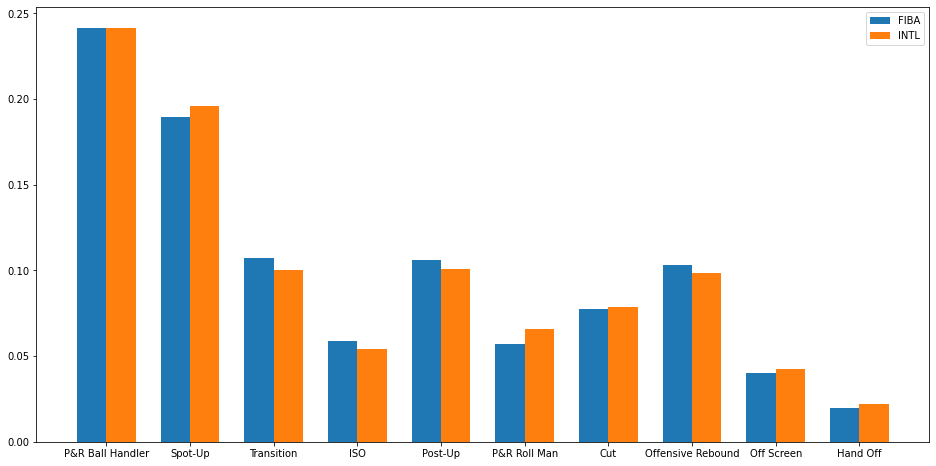

In [23]:
plt.figure(figsize = (16,8))
plt.bar([i for i in range(10)], fiba_df[['% ' + p for p in play_types]].mean(), width = 0.35, label = 'FIBA')
plt.bar([i+0.35 for i in range(10)], nba_intl_df[['% ' + p for p in play_types]].mean(), width = 0.35, label = 'Club')
plt.xticks([i+0.175 for i in range(10)], play_types)
plt.legend()
plt.show()

In [24]:
clust_df.groupby('Cluster')['Source'].value_counts(normalize = True)

Cluster  Source
0        FIBA      0.517588
         INTL      0.371859
         NBA       0.110553
1        FIBA      0.500000
         INTL      0.394068
         NBA       0.105932
2        FIBA      0.501832
         INTL      0.388278
         NBA       0.109890
3        FIBA      0.443609
         INTL      0.315789
         NBA       0.240602
4        FIBA      0.480620
         INTL      0.387597
         NBA       0.131783
5        FIBA      0.538462
         INTL      0.397436
         NBA       0.064103
6        FIBA      0.500000
         INTL      0.351064
         NBA       0.148936
Name: Source, dtype: float64

In [25]:
clust_df['Cluster']

5827    1
5787    5
5791    2
5937    2
7407    6
       ..
728     6
946     2
650     6
794     6
385     6
Name: Cluster, Length: 1314, dtype: int32

In [26]:
clust_df[(clust_df['Source']=='NBA')&(clust_df['Cluster']==5)]

,index,Player,P&R Ball Handler,Spot-Up,Transition,ISO,Post-Up,P&R Roll Man,Cut,Offensive Rebound,...,% Spot-Up,% Transition,% ISO,% Post-Up,% P&R Roll Man,% Cut,% Offensive Rebound,% Off Screen,% Hand Off,Cluster
359,359,DeMarcus Cousins,194,1395,914,1305,2951,1293,468,890,...,0.143400,0.093956,0.134149,0.303351,0.132915,0.048109,0.091488,0.021279,0.011410,5
393,393,Nikola Vucevic,53,1168,463,366,3176,1911,880,1246,...,0.123064,0.048783,0.038563,0.334633,0.201349,0.092719,0.131282,0.018544,0.005479,5
134,134,Marc Gasol,36,1181,473,496,3525,2014,671,588,...,0.127911,0.051229,0.053720,0.381783,0.218131,0.072674,0.063685,0.019279,0.007690,5
819,819,Nikola Jokic,279,799,378,367,2021,1103,680,1007,...,0.115713,0.054743,0.053150,0.292686,0.159739,0.098479,0.145836,0.034613,0.004634,5
395,395,Pau Gasol,35,1055,330,367,2159,1255,608,838,...,0.156157,0.048845,0.054322,0.319568,0.185761,0.089994,0.124038,0.010361,0.005773,5
116,116,Jonas Valanciunas,15,299,287,170,1960,1187,1146,1433,...,0.045698,0.043864,0.025982,0.299557,0.181415,0.175149,0.219013,0.005196,0.001834,5
62,62,Nene Hilario,26,328,308,288,1166,825,653,462,...,0.080432,0.075527,0.070623,0.285924,0.202305,0.160128,0.113291,0.004414,0.000981,5
268,268,Donatas Motiejunas,16,373,174,29,568,314,316,296,...,0.177281,0.082700,0.013783,0.269962,0.149240,0.150190,0.140684,0.005228,0.003327,5
789,789,Boban Marjanovic,0,39,43,4,594,160,180,337,...,0.028676,0.031618,0.002941,0.436765,0.117647,0.132353,0.247794,0.000000,0.002206,5
1010,1010,Georgios Papagiannis,1,8,4,0,65,33,37,42,...,0.041451,0.020725,0.000000,0.336788,0.170984,0.191710,0.217617,0.005181,0.010363,5


In [39]:
df.columns

Index(['index', 'Player', 'P&R Ball Handler', 'Spot-Up', 'Transition', 'ISO',
       'Post-Up', 'P&R Roll Man', 'Cut', 'Offensive Rebound', 'Off Screen',
       'Hand Off', 'Total', 'Source', 'Type', '% P&R Ball Handler',
       '% Spot-Up', '% Transition', '% ISO', '% Post-Up', '% P&R Roll Man',
       '% Cut', '% Offensive Rebound', '% Off Screen', '% Hand Off',
       'Cluster'],
      dtype='object')

In [44]:
df

,index,P&R Ball Handler,Spot-Up,Transition,ISO,Post-Up,P&R Roll Man,Cut,Offensive Rebound,Off Screen,...,% Spot-Up,% Transition,% ISO,% Post-Up,% P&R Roll Man,% Cut,% Offensive Rebound,% Off Screen,% Hand Off,Cluster
Player,,,,,,,,,,,,,,,,,,,,,
Bogdan Bogdanovic,41,352,167,96,94,31,1,34,31,87,...,0.173597,0.099792,0.097713,0.032225,0.001040,0.035343,0.032225,0.090437,0.071726,1
Luis Scola,1,0,122,105,19,304,167,125,97,20,...,0.127083,0.109375,0.019792,0.316667,0.173958,0.130208,0.101042,0.020833,0.001042,5
Facundo Campazzo,5,595,74,140,70,0,2,9,24,16,...,0.077164,0.145985,0.072993,0.000000,0.002086,0.009385,0.025026,0.016684,0.030240,2
Mantas Kalnietis,151,684,69,58,36,3,0,15,23,19,...,0.074114,0.062299,0.038668,0.003222,0.000000,0.016112,0.024705,0.020408,0.025779,2
Bojan Bogdanovic,1621,205,119,113,149,124,2,39,22,92,...,0.136156,0.129291,0.170481,0.141876,0.002288,0.044622,0.025172,0.105263,0.010297,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BJ Johnson,1300,6,16,14,3,0,0,2,5,1,...,0.313725,0.274510,0.058824,0.000000,0.000000,0.039216,0.098039,0.019608,0.078431,6
Yante Maten,1307,2,13,7,2,0,5,9,11,0,...,0.254902,0.137255,0.039216,0.000000,0.098039,0.176471,0.215686,0.000000,0.039216,0
Tornike Shengelia,385,11,8,6,8,5,2,3,4,3,...,0.160000,0.120000,0.160000,0.100000,0.040000,0.060000,0.080000,0.060000,0.000000,6


In [59]:
cols = play_types + ['Cluster']
cols

['P&R Ball Handler',
 'Spot-Up',
 'Transition',
 'ISO',
 'Post-Up',
 'P&R Roll Man',
 'Cut',
 'Offensive Rebound',
 'Off Screen',
 'Hand Off',
 'Cluster']

In [54]:
[source +'_' + play_type for source in ['FIBA', 'INTL', 'NBA'] for play_type in play_types]

['FIBA_P&R Ball Handler',
 'FIBA_Spot-Up',
 'FIBA_Transition',
 'FIBA_ISO',
 'FIBA_Post-Up',
 'FIBA_P&R Roll Man',
 'FIBA_Cut',
 'FIBA_Offensive Rebound',
 'FIBA_Off Screen',
 'FIBA_Hand Off',
 'INTL_P&R Ball Handler',
 'INTL_Spot-Up',
 'INTL_Transition',
 'INTL_ISO',
 'INTL_Post-Up',
 'INTL_P&R Roll Man',
 'INTL_Cut',
 'INTL_Offensive Rebound',
 'INTL_Off Screen',
 'INTL_Hand Off',
 'NBA_P&R Ball Handler',
 'NBA_Spot-Up',
 'NBA_Transition',
 'NBA_ISO',
 'NBA_Post-Up',
 'NBA_P&R Roll Man',
 'NBA_Cut',
 'NBA_Offensive Rebound',
 'NBA_Off Screen',
 'NBA_Hand Off']

In [60]:
total_df = pd.DataFrame(index = df.index.unique(), columns = [source +'_' + col for source in ['FIBA', 'INTL', 'NBA'] for col in cols])
for source in ['FIBA', 'INTL', 'NBA']:
    temp_df = df[df['Source']==source]
    for player in df.index.unique():
        try:
            total_df.loc[player][[source + '_' + col for col in cols]] = temp_df.loc[player][[col for col in cols]]
            
        except:
            pass
            

In [64]:
total_df.to_csv("NBA_INTL_FIBA_Clustering.csv")